# 0. 파일 불러오기

* 주어진 Test set에 Target (Survived)가 없으므로, Train set 을 다시 Train과 Test로 나눠서 결과 도출

In [3]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/KUBIG"
df_train = pd.read_csv(PATH+"/train.csv")

Mounted at /content/drive


# 1 EDA

## 1.1 Data 살펴보기

* PassengerID = ID
* Survived : 0 = 사망, 1 = 생존  **(Target Variable)**
* Pclass : 1 = 1등석, 2 = 2등석, 3 = 3등석
* Name = 이름
* Sex : male = 남성, female = 여성
* Age : 나이
* SibSp : 타이타닉 호에 동승한 자매 / 배우자의 수
* Parch : 타이타닉 호에 동승한 부모 / 자식의 수
* Ticket : 티켓 번호
* Fare : 승객 요금
* Cabin : 방 호수
* Embarked : 탑승지, C = 셰르부르, Q = 퀸즈타운, S = 사우샘프턴

In [4]:
df_train.shape

(891, 12)

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# 결측치에 대한 조치가 필요 (제거 / 보간)
# Encoding이 필요한 범주형 변수 : Name / Sex / Ticket / Cabin / Embarked
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 1.2 Data 시각화



### 주의해야할 부분
1. Fare변수에 Outlier 존재. 특히, Survived = 1 인 경우일 때 Outlier가 존재하므로 이상치에 대한 처리가 필요.

2. Survived = 1 에 대한 Fare의 Boxplot이 Survived = 0에 대한 Fare의 Boxplot보다 범위가 확연히 넓음

3. Pclass와 Fare의 연관성

4. Male의 사망률이 Female의 사망률보다 높음

5. Target Variable 비율의 차이 (Survived = 0 : 62%, Survived = 1 : 38%)



**결국 Fare가 중요한 입력 변수가 될 것이라고 예측 가능**

In [11]:
# 전체적인 시각화 : Autoviz 패키지 이용 (밑의 Wordcloud는 무시)
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline
AV = AutoViz_Class()

df_auto = AV.AutoViz(PATH+"/train.csv", depVar='Survived')

Output hidden; open in https://colab.research.google.com to view.

### 1.2.1 Fare에 대한 시각화

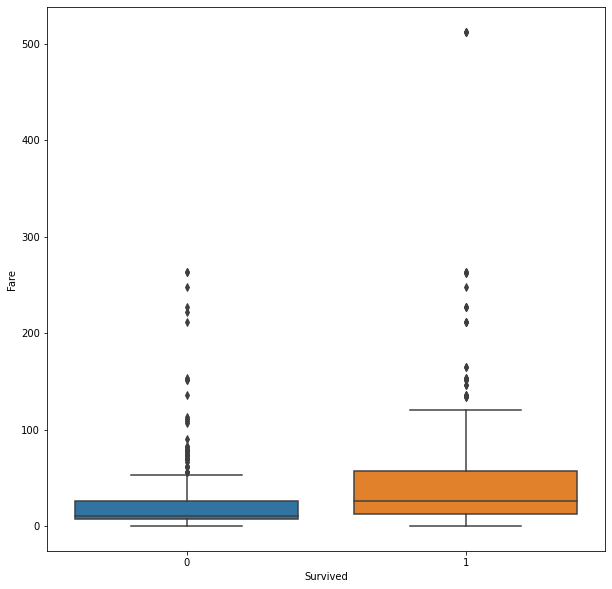

In [8]:
# Fare vs Survived (Survived = 1 일 때, Fare에 Outlier 존재)
# Fare를 표준화하거나 / Outlier을 삭제해야함

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Survived', y = 'Fare', data = df_train)
sns.set_theme(style='whitegrid')
plt.show()

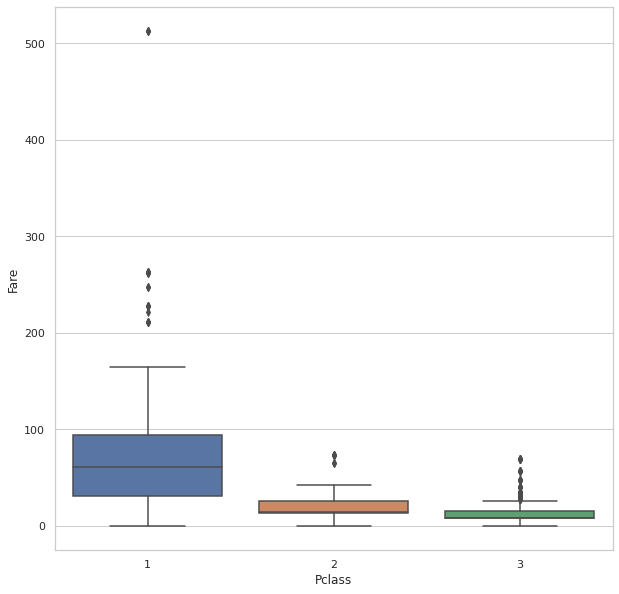

In [9]:
# Fare vs Pclass (좌석등급이 높아질수록 Fare 또한 높아짐)

plt.figure(figsize = (10, 10))
sns.boxplot(x = 'Pclass', y = 'Fare', data = df_train)
plt.show()

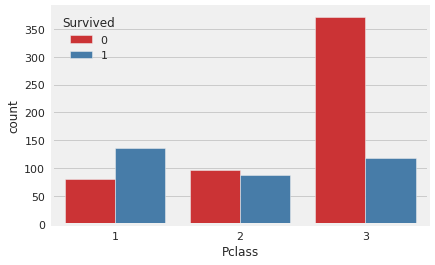

In [12]:
# Pclass vs Survived (좌석등급이 높아질수록 사망자수가 줄어듦. 생존과 사망비율 또한 급격한 차이가남)
sns.countplot(x = 'Pclass', hue = 'Survived',  data = df_train)
plt.show()

### 1.2.2 성별에 따른 Survived 시각화

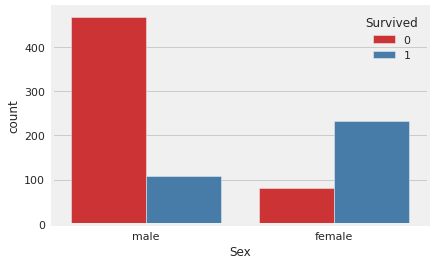

In [13]:
# Sex vs Survived (Male : 사망자 >>> 생존자 / Female : 사망자 << 생존자)
sns.countplot(x = 'Sex', hue = 'Survived',  data = df_train)
plt.show()

### 1.2.3 Survived 비율 시각화

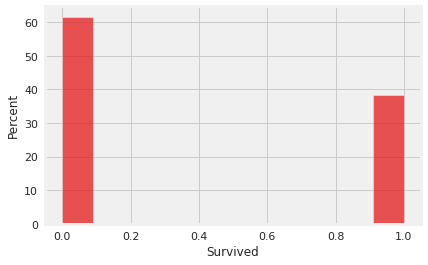

In [14]:
# Survived 비율 (62% / 38%)
# 매우 불균형한 정도까지는 아니므로 별다른 처리 없이 진행

sns.histplot(x = 'Survived', stat = 'percent', data = df_train)
plt.show()

Fare와 Pclass는 서로 상관이 있으며, Target Variable인 Survived와도 상관관계가 있다고 볼 수 있음. 중요한 변수임.

## 1.3 결측치의 처리

In [15]:
# Age의 결측 비율 : 19.8% / Carbin의 결측 비율 : 77.1% / Embarked의 결측 비율 : 0.22%
df_train.isnull().sum()/df_train.shape[0]*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

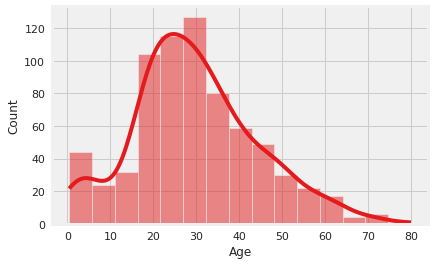

In [16]:
sns.histplot(x=df_train['Age'], bins=15, kde=True)
plt.show()

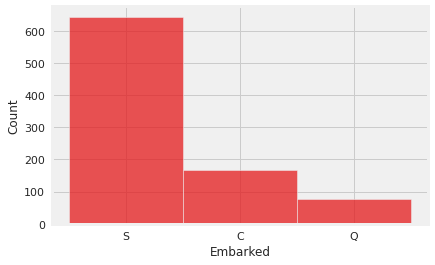

In [17]:
sns.histplot(x=df_train['Embarked'])
plt.show()

In [18]:
# 결측치의 비율이 매우 큰 Cabin을 Feature에서 제외 (모형의 임의성을 피하기 위해)
df_train = df_train.drop(columns = ['Cabin'])


# Age의 평균 : 29.6, 중위값 : 28 이므로 결측치를 28로 대체
df_train.Age.describe()
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())


# Embarked : 범주형 변수이므로 최빈값인 S로 결측치 대체
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode())

## 1.4 변수 제거

생존여부와 연관이 없는 PassengerID, Name, Ticket을 제거함 (직관적) 

In [19]:
df_train = df_train.drop(columns = ['PassengerId', 'Name', 'Ticket'])

## 1.5 Fare value 이상치 제거 

In [20]:
# IQR
Q1 = np.percentile(df_train['Fare'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_train['Fare'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(df_train['Fare'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_train['Fare'] <= (Q1-1.5*IQR))
 

''' Removing the Outliers '''
df_train.drop(upper[0], inplace = True)
df_train.drop(lower[0], inplace = True)

In [21]:
df_train.shape

(775, 8)

# 2 Classification Method (Logistic Regression, LDA/QDA)

## 2.1 범주형 변수 Encoding

In [22]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# Sex와 Embarked 변수를 Encoding
from sklearn.preprocessing import LabelEncoder 
classle = LabelEncoder()

X.Sex = classle.fit_transform(X['Sex'].values)
print(np.unique(X.Sex))
X.Embarked = classle.fit_transform(X['Embarked'].values)
print(np.unique(X.Embarked))

X.head()

[0 1]
[0 1 2]


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2
5,3,1,28.0,0,0,8.4583,1


## 2.2 Train / Test split with Stratifying

In [23]:
# stratify 옵션을 이용하여 y 값으로 층화하여 표본 추출 (Y = 0/1 비율을 보정하여 추출)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2023, stratify=y)

## 2.3 Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(C=1e2, multi_class='ovr',random_state=1)  # C = 1/λ. 디폴트: L2, auto (One-versus-Rest-'ovr').  

Logit.fit(X_train, y_train)
y_train_pred = Logit.predict(X_train)
y_test_pred = Logit.predict(X_test)

In [25]:
# Accuracy score
from sklearn.metrics import accuracy_score, f1_score
print('Train Accuracy:', np.round(accuracy_score(y_train,y_train_pred), 3))   
print('Test Accuracy:', np.round(accuracy_score(y_test,y_test_pred), 3))
print()
print('Train F1 Score:', np.round(f1_score(y_train,y_train_pred), 3))   
print('Test F1 Score:', np.round(f1_score(y_test,y_test_pred), 3))   

Train Accuracy: 0.797
Test Accuracy: 0.76

Train F1 Score: 0.694
Test F1 Score: 0.622


## 2.4 CV를 이용한 Logistic Regression, LDA, QDA

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Define cross_val function with classifer and num_splits as input
def cross_val(classifier,X=X,y=y, num_splits=20):
    
    # Initialize classifier
    model = classifier

    # Obtain scores of cross-validation
    scores = cross_val_score(model, X, y, cv=num_splits)

    # Display accuracy
    print('Accuracy:', np.round(scores, 2))

    # Display mean accuracy
    print('Accuracy mean: %0.2f' % (scores.mean()))

In [27]:
# Use cross_val function to score LogisticRegression
cross_val(LogisticRegression(),X=X,y=y)

Accuracy: [0.77 0.9  0.77 0.82 0.77 0.77 0.64 0.85 0.85 0.77 0.79 0.79 0.77 0.72
 0.79 0.87 0.79 0.76 0.82 0.82]
Accuracy mean: 0.79


In [28]:
# Use cross_val function to score LDA
cross_val(LinearDiscriminantAnalysis(),X=X,y=y)

Accuracy: [0.77 0.9  0.72 0.82 0.77 0.72 0.72 0.87 0.85 0.74 0.79 0.74 0.77 0.74
 0.72 0.84 0.76 0.76 0.79 0.79]
Accuracy mean: 0.78


In [29]:
# Use cross_val function to score QDA
cross_val(QuadraticDiscriminantAnalysis(),X=X,y=y)

Accuracy: [0.69 0.82 0.74 0.82 0.79 0.77 0.59 0.87 0.87 0.77 0.77 0.82 0.79 0.74
 0.77 0.87 0.74 0.79 0.82 0.82]
Accuracy mean: 0.78


# 3 PCA를 이용한 차원축소 후 Classification

## 3.1 앞과 동일한 전처리

In [31]:
# 결측치 처리 / 변수제거까지 앞과 동일
df_train = pd.read_csv(PATH+"/train.csv")
df_train = df_train.drop(columns = ['Cabin'])
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode())
df_train = df_train.drop(columns = ['PassengerId', 'Name', 'Ticket'])

# Input Variable과 Target Variable 분리
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# 범주형 자료 인코딩 
from sklearn.preprocessing import LabelEncoder 
classle = LabelEncoder()
X.Sex = classle.fit_transform(X['Sex'].values); X.Embarked = classle.fit_transform(X['Embarked'].values)

# Train / Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2023, stratify=y)


# Data 표준화 (요번에는 이상치 제거를 하지 않고 표준화를 이용)
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)


# 고유값, 고유벡터 구하기
import numpy as np
scov=np.cov(X_train_std.T)
eigen_vals, eigen_vecs=np.linalg.eig(scov)
print('Eigenvalues \n%s' %eigen_vals)

Eigenvalues 
[1.93142734 1.68543675 0.32633171 0.98193756 0.71040105 0.84627022
 0.52944939]


## 3.2 PCA 과정

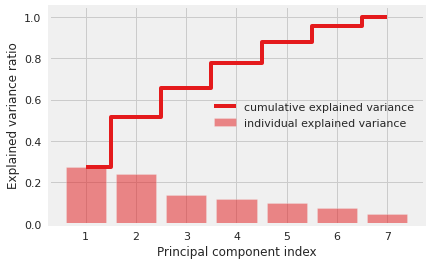

In [34]:
# Explained variance ratio
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,8), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,8), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

## 3.3 Logistic Regression

In [35]:
# 4개의 주성분까지 선택 (대략 80%)
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
lr=LogisticRegression()
lpca = PCA(n_components=4)
X_train_pca = lpca.fit_transform(X_train_std)
X_test_pca = lpca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
y_train_pre=lr.predict(X_train_pca)
y_test_pre=lr.predict(X_test_pca)

In [43]:
from sklearn import metrics
print('Train Accuracy:', np.round(metrics.accuracy_score(y_train, y_train_pre),3))
print('Test Accuracy:', np.round(metrics.accuracy_score(y_test, y_test_pre),3))
print()
print('Train F1 Score:', np.round(metrics.f1_score(y_train,y_train_pre), 3))   
print('Test F1 Score:', np.round(metrics.f1_score(y_test,y_test_pre), 3)) 

Train Accuracy: 0.798
Test Accuracy: 0.78

Train F1 Score: 0.721
Test F1 Score: 0.706


# 3 정리
 * PCA를 이용하여 차원축소를 하기 전 Logistic Regression, LDA, QDA를 비교해보았을 때, Accuracy 측면에서 거의 유사함
 * PCA를 이용하지 않은 Logistic Regression Model과 PCA를 이용한 Logistic Regression 모델을 비교해보았을 때, Accuracy는 유사했지만, PCA를 하였을 때, F1 Score가 다소 증가하였음
    * 이는 PCA의 결과일지, 데이터의 표준화에 따른 결과일지 더 다양한 모델로 비교해보아야할 필요성이 존재.
    * 또한, 단순히 한번의 임의적인 Train/Test Split에 따른 결과이므로 CV와 같은 다양한 방법으로 비교해보아야함. 